<a href="https://colab.research.google.com/github/hsuanlion/RecommendationSystem/blob/main/week3/Collaborative_Filtering_Experience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 協同過濾

## 基礎建設

In [1]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-09 11:49:32--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.7’

All_Beauty.csv.7    100%[===================>]  14.78M  71.3MB/s    in 0.2s    

2022-01-09 11:49:32 (71.3 MB/s) - ‘All_Beauty.csv.7’ saved [15499476/15499476]

--2022-01-09 11:49:32--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.7’

meta_All_Beauty.jso 100%[===================>]   9.85M  63.4MB/s    in 0.2s   

In [3]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [5]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [6]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [4]:
# DATE
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

### 資料清洗

In [5]:
metadata['category_'] = metadata['rank'].str.split(pat='in',expand=True)[1].str.replace(" \(","").str.replace('&amp;',"&").str.strip()
metadata['rank_n'] = pd.to_numeric(metadata['rank'].str.split('in',expand= True)[0].str.replace(',',''))
metadata['price_'] = pd.to_numeric(metadata['price'].str.replace("$",""),errors='coerce')
metadata_filterd = metadata.loc[metadata.category_ == "Beauty & Personal Care",['asin', 'brand', 'title', 'price_', 'description','also_view','also_buy','rank_n',"category_"]].copy()
metadata_filterd

,asin,brand,title,price_,description,also_view,also_buy,rank_n,category_
0,6546546450,idea village,Loud 'N Clear&trade; Personal Sound Amplifier,NaN,[Loud 'N Clear Personal Sound Amplifier allows...,[],[],2938573.0,Beauty & Personal Care
1,7178680776,,No7 Lift &amp; Luminate Triple Action Serum 50...,44.99,[No7 Lift & Luminate Triple Action Serum 50ml ...,[],"[B01E7LCSL6, B008X5RVME]",872854.0,Beauty & Personal Care
2,7250468162,No7,No7 Stay Perfect Foundation Cool Vanilla by No7,28.76,[No7 Stay Perfect Foundation now stays perfect...,"[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]",[],956696.0,Beauty & Personal Care
3,7367905066,,Wella Koleston Perfect Hair Colour 44/44 Mediu...,NaN,[],[],[B0041PBXX8],1870258.0,Beauty & Personal Care
4,7414204790,Pirmal Healthcare,Lacto Calamine Skin Balance Oil control 120 ml...,12.15,[Lacto Calamine Skin Balance Daily Nourishing ...,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...",[],67701.0,Beauty & Personal Care
...,...,...,...,...,...,...,...,...,...
32887,B01HIWLLUK,,"Barielle Pro Textured Grip Cuticle Nipper, Purple",9.95,[],[],[],2145325.0,Beauty & Personal Care
32888,B01HJ1K3YK,Salon Perfect,(Buy 3 Get 1 Free) Salon Perfect Eye Makeup Co...,NaN,[],[],[],1639713.0,Beauty & Personal Care
32889,B01HJ84SGM,,NOW D-Mannose 500 mg - 120 Veg Capsules (Pack ...,55.63,[],"[B01KON9B4S, B000JN4CR0, B071ZHMRHS, B01HJ84TN...","[B01KON9B4S, B079X3YFXS, B00M79OYS6, B000JN4CR...",207410.0,Beauty & Personal Care
32890,B01HJASD20,GBSTORE,12 White Feather Shuttlecocks Birdies Badminto...,12.99,[Brand new and high quality<br> Enables fast v...,[],[],965673.0,Beauty & Personal Care


In [6]:
metadata_filterd.shape

(32380, 9)

In [8]:
metadata_filterd['asin'].nunique()

32015

In [7]:
# metadata 會有重複的資料列
metadata_filterd.groupby('asin').filter(lambda x : len(x) > 1).sort_values('asin')

,asin,brand,title,price_,description,also_view,also_buy,rank_n,category_
23,B000050B60,Norelco,Norelco 4821XL Micro Action Corded/Cordless Re...,NaN,[],"[B01859QG3W, B00JITDVD2]",[],3022008.0,Beauty & Personal Care
427,B000050B60,Norelco,Norelco 4821XL Micro Action Corded/Cordless Re...,NaN,[],"[B01859QG3W, B00JITDVD2]",[],3022008.0,Beauty & Personal Care
25,B000050B62,Norelco,Norelco 5841XL Deluxe Reflex Action Cord/Cordl...,NaN,[Model No. 5841XL. Rechargeable cord/cordless ...,[B00JITDVD2],[],3359846.0,Beauty & Personal Care
429,B000050B62,Norelco,Norelco 5841XL Deluxe Reflex Action Cord/Cordl...,NaN,[Model No. 5841XL. Rechargeable cord/cordless ...,[B00JITDVD2],[],3359846.0,Beauty & Personal Care
431,B000050B63,Norelco,Norelco 6826XL Quadra Action Cord/Cordless Rec...,NaN,[This 7-watt electric razor puts three individ...,[],[],1559090.0,Beauty & Personal Care
...,...,...,...,...,...,...,...,...,...
422,B00032A9TM,Wrigley's,ECLIPSE MINTS WINTERFROST [Health and Beauty] ...,NaN,[],[],[],2266650.0,Beauty & Personal Care
827,B0004E9ILY,Annemarie Borlind,Blush Magic Brown Annemarie Borlind 0.15 oz Co...,NaN,[],[],[],3094362.0,Beauty & Personal Care
423,B0004E9ILY,Annemarie Borlind,Blush Magic Brown Annemarie Borlind 0.15 oz Co...,NaN,[],[],[],3094362.0,Beauty & Personal Care
424,B0004RX5TW,Ultra,Ultra (Box of 10) Corn Plane Blades,8.0,"[Ultra (Box of 10) Corn Plane Blades, , ]","[B000BL6JM6, B0002Z8OWO, B07D8YJGNF, B00CIQQ4J...",[],660652.0,Beauty & Personal Care


In [8]:
metadata_filterd = metadata_filterd.drop_duplicates(subset=['asin'])
metadata_filterd.shape

(32015, 9)

## 篩選ratings資料

In [9]:
# 對單一商品有多則評論的用戶清單
IDs_multipleRows = ratings.groupby(['reviewerID','asin']).filter(lambda x: len(x) > 1).reviewerID.unique()
IDs_multipleRows

array(['AD80MGOY5CJZ4', 'ACTVXNBEPLW2S', 'A2CTM1BYAXTYLX', ...,
       'A1FPP3D30OHLG6', 'A35ZSECOBJX4XM', 'A2096UL86CQ23X'], dtype=object)

In [9]:
# 將對單一商品有多則評論的紀錄依據時間新到舊排列
ratings.loc[ratings['reviewerID'].isin(IDs_multipleRows)].sort_values(['reviewerID','asin','DATE'],ascending=False) 
# ratings.sort_values(['reviewerID','asin','DATE'],ascending=False) # .groupby(['reviewerID','asin'],sort=['Date'])

,asin,reviewerID,overall,unixReviewTime,DATE
51214,B000VLYHXY,AZZOXYRZR81N4,5.0,1410307200,2014-09-10
59739,B000VLYHXY,AZZOXYRZR81N4,5.0,1410307200,2014-09-10
52554,B000WYJTZG,AZYF55JCUQVNJ,5.0,1484438400,2017-01-15
61079,B000WYJTZG,AZYF55JCUQVNJ,5.0,1484438400,2017-01-15
53757,B000X2FPXC,AZX812A2LTXNR,3.0,1417305600,2014-11-30
...,...,...,...,...,...
66871,B0014BB6WA,A0673442VROY91O08DED,1.0,1466812800,2016-06-25
51428,B000VV1YOY,A0324832JI7F4KRTTGDO,5.0,1485216000,2017-01-24
59953,B000VV1YOY,A0324832JI7F4KRTTGDO,5.0,1485216000,2017-01-24
55596,B00120VWTK,A0153524HC25D09HXMND,5.0,1470787200,2016-08-10


In [10]:
ratings.shape

(371345, 5)

In [10]:
# 篩選 category, 並取出每個人對每件商品最新的一則評論
ratings_f1 = ratings.loc[ratings['asin'].isin(metadata_filterd['asin'])].sort_values(['reviewerID','asin','DATE'],ascending=False).groupby(['reviewerID','asin']).last().reset_index()
# ratings.loc[ratings['reviewerID'].isin(IDs_multipleRows)].sort_values(['reviewerID','asin','DATE'],ascending=False).groupby(['reviewerID','asin']).last()

ratings_f1.shape

(351946, 5)

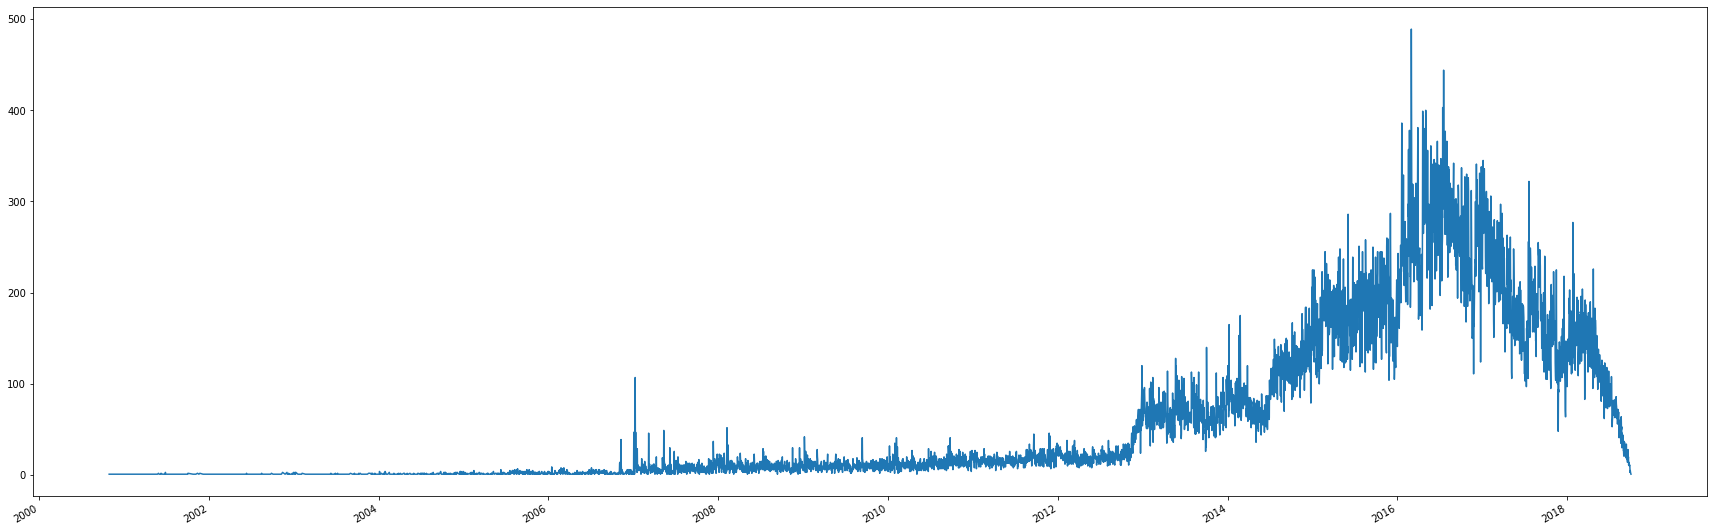

In [12]:
# 查看評論時間分佈
ratings_f1.sort_values('DATE')['DATE'].value_counts().plot(figsize = (30,10))

In [18]:
ratings_f1['DATE'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  351946
unique                   5253
top       2016-03-01 00:00:00
freq                      489
first     2000-10-29 00:00:00
last      2018-10-02 00:00:00
Name: DATE, dtype: object

ratings_f2:嘗試使用2014以後的資料

In [35]:
ratings_f2 = ratings_f1.loc[ratings_f1['DATE'] >= "2014-01-01"]
ratings_f2.shape

(295034, 5)

## 資料切分

In [36]:
ratings_trainings = ratings_f2[
    (ratings_f1['DATE'] < '2018-09-01')
]
ratings_testings = ratings_f2[
    (ratings_f1['DATE'] >= '2018-09-01') & 
    (ratings_f1['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [33]:
len(users)

578

In [37]:
# 檢查testing data的users 沒有歷史資料個個數：
countU = 0
for user in users:
  if not ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist():
    countU +=1
print('no Historic UU:', countU, "; total testing UU: ", len(users), "; no Historic UU%: ", countU/len(users))

no Historic UU: 544 ; total testing UU:  578 ; no Historic UU%:  0.9411764705882353


In [38]:
# 標記過去有紀錄的users_withRecord
users_withRecord = ratings_trainings.loc[ratings_trainings['reviewerID'].isin(users),'reviewerID'].unique().tolist()
users_withRecord 

['A13JU88JAHN72I',
 'A16Y7V1CZCWKFV',
 'A19503XX7GU6J2',
 'A1EY751AUVO5NZ',
 'A1PR178735XC70',
 'A1SA3N793WT2LM',
 'A1TP9JHTIY468V',
 'A1WEFBEJ7OHSVZ',
 'A28E3FNV1BYC94',
 'A29834GBB4DOP1',
 'A2AAQWBJJTK3E1',
 'A2BU6N5956T9NH',
 'A2GFPTQ4VWDX96',
 'A2IMJV0CQMZLGC',
 'A2IOBG1ERS4JP3',
 'A2JCBLTLYDPQLW',
 'A2M4YSOJZELJ6N',
 'A2XFJ8CTY7VDNN',
 'A2XY3CJ3ZCAD03',
 'A3BE6JK97CYAGA',
 'A3BT1WLPENXMD6',
 'A3H8Z7JS7XJHJJ',
 'A3JEQJCEMX20GI',
 'A4IQXCCXDEAKW',
 'A7JUHUYLXIUVQ',
 'A7Y4ETTLARUGI',
 'ACE1ZIOI3U6PY',
 'AGRZQOBCF8H87',
 'AITF34BGBMVJJ',
 'AK7YIZE6ZZ1N9',
 'ANR73TPVBCQ9K',
 'AQYL4TDY2HU8Z',
 'ASGIVOW34XNQS',
 'ATJRZUXNWAWIK']

## 產生推薦 (CF - User Filter)

In [39]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

# header: user_id,item_id,rating,timestamp

def recommender_cf_userBased1(training_data, users=[], k=10):

    # loading data from dataframe
    # user_to_items dict:
    # {
    #   'user': {
    #       'item': ratings...
    #   }...
    # }
    user_to_items = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])

        user_to_items[user][item] = rating

    print("total users before filtering: ", len(user_to_items))

    # remove obscure user to decrease data size
    # filtering params
    remove_obscure_user = True
    user_rating_threshold = 3
    all_users = list(user_to_items.keys())
    for user in all_users:
        ratings = user_to_items[user]
        if remove_obscure_user and len(ratings) < user_rating_threshold:
            del user_to_items[user]

    print("total users  after filtering: ", len(user_to_items))

    # generate item to user mapping dict
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for user, items in user_to_items.items():
        for item, rating in items.items():
            item_to_users[item][user] = rating

    # prepare data of computing user similarity 
    init_sim = lambda: [0 for _ in range(3)]
    factory = lambda: defaultdict(init_sim)
    pre_user_similarity = defaultdict(factory)
    n = len(item_to_users)
    index = 0
    for item, user_ratings in item_to_users.items():
        if len(user_ratings) > 1:
            # print(f"item: {item} have been rated by {len(user_ratings)} users progress: {index}/{n}")
            for user1, user2 in combinations(user_ratings.keys(), 2):
                xy = user_ratings[user1] * user_ratings[user2]
                xx = user_ratings[user1] ** 2
                yy = user_ratings[user2] ** 2
                pre_user_similarity[user1][user2][0] += xy
                pre_user_similarity[user1][user2][1] += xx
                pre_user_similarity[user1][user2][2] += yy

                pre_user_similarity[user2][user1][0] += xy
                pre_user_similarity[user2][user1][1] += xx
                pre_user_similarity[user2][user1][2] += yy
        index += 1

    user_similarity = {}
    for src_user in pre_user_similarity:
        user_similarity_order = []
        for dst_user, val in pre_user_similarity[src_user].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(user_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    user_similarity_order.insert(i, (dst_user, similarity))
                    break
            else:
                user_similarity_order.append((dst_user, similarity))
        user_similarity[src_user] = user_similarity_order

    recommendation = {}

    for user in users:
        if user in user_similarity:
            sim_users = user_similarity[user]
            recommended_items = []
            recommended_items_set = set()
            user_have_rated = set(user_to_items[user])
            stop_recommend = False
            for sim_user, _ in sim_users:
                items_from_sim_user = sorted(list(user_to_items[sim_user].items()), key=lambda item: item[1])
                for item, _ in items_from_sim_user:
                    if item not in user_have_rated and item not in recommended_items_set:
                        recommended_items.append(item)
                        recommended_items_set.add(item)
                    if len(recommended_items) >= k:
                        stop_recommend = True
                        break
                if stop_recommend:
                    break
            recommendation[user] = recommended_items
        else:
            recommendation[user] = []
    return recommendation

ratings_by_user = recommender_cf_userBased1(ratings_trainings, users)
ratings_by_user

total users before filtering:  267753
total users  after filtering:  3573


{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': [],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': [],
 'A174YOBOSW9WDN': [],
 'A1786SKRAJXH86': [],
 'A17K2BUZ20WD2': [],
 'A17LYRFV645L0V': [],
 'A18LNGVXDZBTUR': [],
 'A19503XX7GU6J2': [],
 'A19HVHRZDYFEOP': [],
 'A19JM38B861BO4': [],
 'A19KGY3W1P0MH

## 結果評估V1 (CF - User Based)

In [40]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.0

## 結果評估V2 (CF - ) 只篩選有歷史記錄的user清單(_f1)來評估

In [41]:
# dict_you_want = { your_key: old_dict[your_key] for your_key in your_keys }
ratings_testings_by_user_f1 = { user: ratings_testings_by_user[user] for user in users_withRecord }
ratings_by_user_f1 = {user:ratings_by_user[user] for user in users_withRecord}

def evaluate_v2(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user_f1, ratings_by_user_f1)

0.0

In [63]:
ratings_testings_by_user_f1

{'A13JU88JAHN72I': ['B017I6B6GK'],
 'A16Y7V1CZCWKFV': ['B01E54U1RI'],
 'A19503XX7GU6J2': ['B01CTQC9J2'],
 'A1EY751AUVO5NZ': ['B01E54U1RI'],
 'A1PR178735XC70': ['B01CRSWZAU'],
 'A1SA3N793WT2LM': ['B01GAFCQOQ'],
 'A1TP9JHTIY468V': ['B01CT5SNQQ'],
 'A1UAOE8KO7Q1DZ': ['B01DL7KJ04'],
 'A1WEFBEJ7OHSVZ': ['B0178H2LK4'],
 'A1WSZED2O5MA5T': ['B018WCT01C'],
 'A28E3FNV1BYC94': ['B0195R1FT8'],
 'A29834GBB4DOP1': ['B01G00BHN2'],
 'A2AAQWBJJTK3E1': ['B01BI8YFAS'],
 'A2BU6N5956T9NH': ['B01FDO0GNI'],
 'A2GFPTQ4VWDX96': ['B01FT94H1Y'],
 'A2IMJV0CQMZLGC': ['B016YROO36'],
 'A2IOBG1ERS4JP3': ['B01F1Y2YSK'],
 'A2JCBLTLYDPQLW': ['B01F47TKXQ'],
 'A2M4YSOJZELJ6N': ['B01DKQAXC0'],
 'A2XFJ8CTY7VDNN': ['B01CTQC9J2'],
 'A2XY3CJ3ZCAD03': ['B01D8BV4VG'],
 'A3BE6JK97CYAGA': ['B01GCLNY6C'],
 'A3BT1WLPENXMD6': ['B01E7UKR38'],
 'A3DXW3542E4QUC': ['B01D575H1G'],
 'A3GRQ9WMP4OXFE': ['B01HFT13NG'],
 'A3H8Z7JS7XJHJJ': ['B01FWP41H0'],
 'A3JEQJCEMX20GI': ['B01FNIZH6A'],
 'A4IQXCCXDEAKW': ['B01GK8P0CS'],
 'A7JUHUYLXIUVQ': ['B

In [48]:
len(ratings_testings_by_user_f1)

34

In [42]:
ratings_by_user_f1

{'A13JU88JAHN72I': [],
 'A16Y7V1CZCWKFV': [],
 'A19503XX7GU6J2': [],
 'A1EY751AUVO5NZ': [],
 'A1PR178735XC70': [],
 'A1SA3N793WT2LM': ['B00FIUEIY6',
  'B018QQU0YK',
  'B000FOI48G',
  'B000GLRREU',
  'B00ARBOMTM',
  'B001DKQ47E',
  'B00U1VSN98',
  'B00TUAK3QW',
  'B00TUAMC4S',
  'B000GLB37M'],
 'A1TP9JHTIY468V': [],
 'A1WEFBEJ7OHSVZ': [],
 'A28E3FNV1BYC94': [],
 'A29834GBB4DOP1': [],
 'A2AAQWBJJTK3E1': [],
 'A2BU6N5956T9NH': [],
 'A2GFPTQ4VWDX96': [],
 'A2IMJV0CQMZLGC': [],
 'A2IOBG1ERS4JP3': [],
 'A2JCBLTLYDPQLW': [],
 'A2M4YSOJZELJ6N': [],
 'A2XFJ8CTY7VDNN': [],
 'A2XY3CJ3ZCAD03': [],
 'A3BE6JK97CYAGA': [],
 'A3BT1WLPENXMD6': [],
 'A3H8Z7JS7XJHJJ': [],
 'A3JEQJCEMX20GI': [],
 'A4IQXCCXDEAKW': [],
 'A7JUHUYLXIUVQ': [],
 'A7Y4ETTLARUGI': [],
 'ACE1ZIOI3U6PY': ['B00PMRE5A2', 'B00QHX7NT0', 'B01E7UKR38'],
 'AGRZQOBCF8H87': [],
 'AITF34BGBMVJJ': [],
 'AK7YIZE6ZZ1N9': [],
 'ANR73TPVBCQ9K': [],
 'AQYL4TDY2HU8Z': [],
 'ASGIVOW34XNQS': [],
 'ATJRZUXNWAWIK': []}

In [43]:
user_withResult = 0
for user, items in ratings_by_user_f1.items():
  if len(items) > 1:
    user_withResult += 1
user_withResult

2

## CF - User Based小結

CF - User Based的推薦結果
1. 因為預設將training data小於等於2筆的使用者評分資料刪除，所以訓練資料的BASE就從31萬減少為4662筆（1.4%)。 導致說，在投入新的測試資料時，能比對的相似用戶範圍就變少很多。
  - total users before filtering:  314769
  - total users  after filtering:  4662
2. 再加上測試資料中的540筆使用者中，只有38位使用者有歷史評分紀錄，而再加上上述第一點的範圍限制，導致34位使用者只有2位有推薦清單結果，且很不幸的推薦清單都沒有中。
3. 在訓練基礎有效資料有限的情況，加上測試資料幾乎都是全新用戶的情況，CF-User Base的效果不甚理想。


## 產生推薦 (CF - Item Based)

In [44]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

def recommender_cf_itemBased1(training_data, users=[], k=10):

    # loading data from dataframe
    # item_to_users dict:
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])
        item_to_users[item][user] = rating

    print("data converted")
    print("total items before inverted: ", len(item_to_users))

    user_to_items = defaultdict(dict)
    for item, rating_users in item_to_users.items():
        for user, rating in rating_users.items():
            user_to_items[user][item] = rating

    print("data inverted")
    

    init_sim = lambda: [0, 0, 0]
    factory = lambda: defaultdict(init_sim)
    pre_item_similarity = defaultdict(factory)
    for user, items in user_to_items.items():
        if len(items) > 1:
            for i1, i2 in combinations(items.keys(), 2):
                xy = items[i1] * items[i2]
                xx = items[i1] ** 2
                yy = items[i2] ** 2
                pre_item_similarity[i1][i2][0] += xy
                pre_item_similarity[i1][i2][1] += xx
                pre_item_similarity[i1][i2][2] += yy

                pre_item_similarity[i2][i1][0] += xy
                pre_item_similarity[i2][i1][1] += xx
                pre_item_similarity[i2][i1][2] += yy

    print("sim data prepared")

    item_similarity = {}
    for src_item in pre_item_similarity:
        item_similarity_order = []
        for dst_item, val in pre_item_similarity[src_item].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(item_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    item_similarity_order.insert(i, (dst_item, similarity))
                    break
            else:
                item_similarity_order.append((dst_item, similarity))
        item_similarity[src_item] = item_similarity_order

    print(f"get {k} recommendation items for for user: {users}")

    recommendation = {}
    for user in users:
        items = []
        items_set = set()
        stop = False
        user_has_rated = set(user_to_items[user])
        for item in user_has_rated:
            if item in item_similarity:
                for sim_item, _ in item_similarity[item]:
                    # skip the item user has rated
                    if sim_item not in user_has_rated and sim_item not in items_set:
                        items.append(sim_item)
                        items_set.add(sim_item)
                    if len(items) >= k:
                        stop = True
                        break
                if stop:
                    break
        recommendation[user] = items

    # print(item_similarity)
    return recommendation    

ratings_by_user_2 = recommender_cf_itemBased1(ratings_trainings, users)
ratings_by_user_2

data converted
total items before inverted:  29455
data inverted
sim data prepared
get 10 recommendation items for for user: ['A100XQFWKQ30O2', 'A103T1QOGFCSEH', 'A106UKKSJ2KXPF', 'A10A7GV4D5A11V', 'A1119JJ37ZLB8R', 'A113UOOLBSZN52', 'A12M4U7WK4ALCR', 'A12T8YTW6VWT7S', 'A1364JXGKB46MM', 'A137DALOQFKBTI', 'A13IV4I1B0RXMG', 'A13JU88JAHN72I', 'A13K55R6VH1OOD', 'A13P7VFU075A', 'A13SWYE4QLB6NG', 'A13ZTQ0Q4ATA41', 'A142EDN04OD62U', 'A142I22FIC8MZK', 'A14834QTII5TLT', 'A14A447VPACTBC', 'A14AP6MN5XO6LB', 'A14CLF25IX25US', 'A14LYXC3HTBAHI', 'A14VUW4KZ34EOE', 'A14Y32P26G9YL', 'A157T25PBS7MX4', 'A15HZDSERD85C8', 'A15JJ8J1FGADIX', 'A15ZCL70JXXH89', 'A1617KN2IAWZ6J', 'A16E0O88262HKA', 'A16NSZ58PTVIYF', 'A16UGDXRTDLJG5', 'A16X9HR3UFQQXY', 'A16Y7V1CZCWKFV', 'A174YOBOSW9WDN', 'A1786SKRAJXH86', 'A17K2BUZ20WD2', 'A17LYRFV645L0V', 'A18LNGVXDZBTUR', 'A19503XX7GU6J2', 'A19HVHRZDYFEOP', 'A19JM38B861BO4', 'A19KGY3W1P0MHT', 'A19KJPOF3QOJ24', 'A19U5RT4Q8Q1T6', 'A1AQNQUNX8B6JT', 'A1ARU0IN6RUFFD', 'A1BB4635KSKDM

{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': [],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': ['B006IB5T4W',
  'B01C4ZAPGM',
  'B017BJ8KFE',
  'B00X3T6FEU',
  'B00NV6DMG4',
  'B01DKI8S1Q',
  'B01E0T6BPE',
  'B00X7G1CII',
  'B01BEWYRJ2',
  'B019RF59O0'],
 'A174YOBOSW9WDN': [],
 'A1786SKRAJXH86': 

## 評估結果 CF - Item Based

只去評估那些有歷史紀錄的用戶的推薦效果

In [45]:
# dict_you_want = { your_key: old_dict[your_key] for your_key in your_keys }
ratings_testings_by_user_f1 = { user: ratings_testings_by_user[user] for user in users_withRecord }
ratings_by_user_2_f1 = {user:ratings_by_user_2[user] for user in users_withRecord}

evaluate_v2(ratings_testings_by_user_f1, ratings_by_user_2_f1)

0.0017123287671232876

In [47]:
user_withRecList = 0
for user, items in ratings_by_user_2_f1.items():
  if len(items) > 1:
    user_withRecList += 1
print("Total Testing Users:",len(ratings_by_user_2_f1),"; Total Testing Users with Recommendations: ",user_withRecList)

Total Testing Users: 34 ; Total Testing Users with Recommendations:  26


## 小結 CF - Item Based

1. 如果改用item based (以training data來說，物品相似度的base多達32009，比之前user base篩選至少要有3則商品評論的參考範圍4600還多)，即使用 item被哪些使用者購買之關係當作推薦依據，只要有至少一筆商品評論的用戶就可以有item based的推薦清單，所以擁有推薦清單的用戶會比user based更多(item base result: 26 out of 34; user base result: 2 out of 34)。
2. 但使用consine similarity計算item相似度的結果，如果商品屬於熱銷商品，用戶又沒有進行分組降維，item_similartiy矩陣的consine Cosine Similarity（餘弦相似度）幾乎清一色都是1（即每件商品的都極相似），表示用原始的用戶評分，不具有商品鑑別度。
3. 評估結果也顯示，34個測試用戶清單的Recall只有0.17%(0.0017123287671232876)，還是不慎理想。
4. 若要優化CF item based, 應該著手於user降維。



## 產生推薦 - Surprise套件 (Item base)

- 使用surprise的Item base
- 並篩選commen數至少大於等於3則者。min-support = 3

In [83]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 6.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619409 sha256=76e030ee64ebfe805d94a85dcf338542bbe1ebe6c650bbce432f925ccba46160
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [54]:
import time
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic

def recommender_cf_surprise(training_data, users=[], k=10, user_based=False, algo=KNNBasic):


    # downsize date volume: 
    training_data = training_data[training_data.DATE >= '2017-09-01']

    training_data = (
        training_data
        .sort_values("DATE", ascending=False)
        .groupby(['reviewerID', 'asin']).head(1)
    )

    reader = Reader(rating_scale=(0, 5))
    training_data = training_data[['reviewerID', 'asin', 'overall']]
    data = Dataset.load_from_df(training_data, reader=reader)

    sim_options = {
        'name': 'cosine',
        'user_based': user_based,  # compute similarities between items
        'min_support': 3
    }
    algo_impl = algo(sim_options=sim_options)
    trainset = data.build_full_trainset()
    algo_impl.fit(trainset)

    recommendation = {}
    for user in users:
        items_user_rated = set(training_data.loc[training_data['reviewerID'] == user]['asin'].to_list())
        recommend_item_list = []
        recommend_item_set = set()
        for item in items_user_rated:
            iid = algo_impl.trainset.to_inner_iid(item)
            recommend_items_iid = algo_impl.get_neighbors(iid, k)
            for sim_item_iid in recommend_items_iid:
                item_raw_id = algo_impl.trainset.to_raw_iid(sim_item_iid)
                if item_raw_id not in items_user_rated and item_raw_id not in recommend_item_set:
                    recommend_item_list.append(item_raw_id)
                    recommend_item_set.add(item_raw_id)

            if len(recommend_item_list) >= k:
                recommend_item_list = recommend_item_list[:k]
                break
        recommendation[user] = recommend_item_list

    return recommendation

ratings_by_user_3 = recommender_cf_surprise(ratings_trainings, users)
ratings_by_user_3

Computing the cosine similarity matrix...
Done computing similarity matrix.


{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': [],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': [],
 'A174YOBOSW9WDN': [],
 'A1786SKRAJXH86': [],
 'A17K2BUZ20WD2': [],
 'A17LYRFV645L0V': [],
 'A18LNGVXDZBTUR': [],
 'A19503XX7GU6J2': ['B01HEYYRIK',
  'B01DKQAXC0',
  'B012Z7IHHI',
  'B014I56NSU',
  

In [55]:
# dict_you_want = { your_key: old_dict[your_key] for your_key in your_keys }
ratings_testings_by_user_f1 = { user: ratings_testings_by_user[user] for user in users_withRecord }
ratings_by_user_3_f1 = {user:ratings_by_user_3[user] for user in users_withRecord}

def evaluate_v2(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score


evaluate_v2(ratings_testings_by_user_f1, ratings_by_user_3_f1)

0.003424657534246575

In [56]:
user_withRecList = 0
for user, items in ratings_by_user_3_f1.items():
  if len(items) > 1:
    user_withRecList += 1
print("Total Testing Users:",len(ratings_by_user_3_f1),"; Total Testing Users with Recommendations: ",user_withRecList)

Total Testing Users: 34 ; Total Testing Users with Recommendations:  13


## 小結 CF - using Surprise package
1. 使用套件執行user base協同過濾的結果，一樣限制至少要有三筆評論紀錄，有清單的用戶數有變多(surprise套件：13 out of 34,  手刻user based: 2 out of 34)。
2. 且雖然使用的training data scope更少(前面兩個方法用2014以後的資料，此法則使用2017-09月以後的資料)，清單的 Recall也是三個方法中最高的0.34%。
